# Applying k-means to real datasets

`Espen Fanavoll`

In a previous notebook the k-means algorithm was demonstrated by coding it from scratch and applying it to some artficial two-dimensional clusters. Now I will demonstrate the use of the sklearn KMeans algorithm on some real world data sets.

Note that while k-means is an algorithm for grouping *unlabelled* data, the datasets we are using here are labelled, and we'll be albe to evaluate the performance using the known target labels.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets
from matplotlib import pyplot as plt
import seaborn as sns

# The iris dataset

<img align="right" width="330" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Iris_virginica_2.jpg/440px-Iris_virginica_2.jpg">

The iris dataset is a popular database (first published in 1936!) containing 150 measurements of three different species of the iris flower. Four different dimensions of the flower are included, meaning we are looking at clustering in a four-dimensional hypercube.

First we will load the dataset and plot the features using a `PairGrid`

In [2]:
iris = datasets.load_iris()
samples = iris.data
print(dir(iris))
print(iris.feature_names)
print(iris.target_names)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


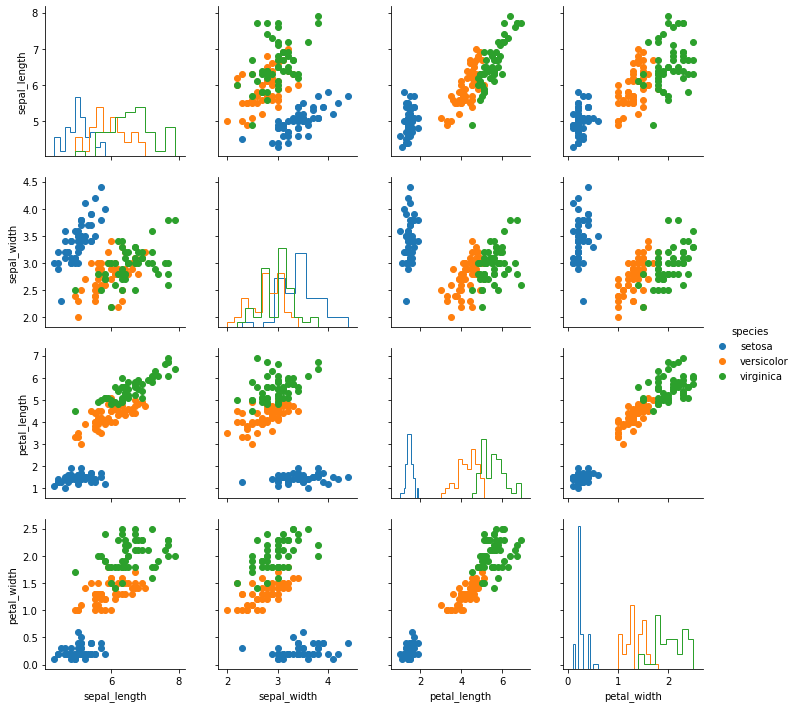

In [3]:
df = pd.DataFrame(iris.data, columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df['species'] = [iris.target_names[i] for i in iris.target]
g = sns.PairGrid(data = df, hue = 'species')
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist, histtype="step")
g = g.add_legend()
plt.show()

The grid above compares the four features of the iris dataset. Already we can see that the data forms clusters in most of the comparisons, with one species clearly separated, while the other two are closer together. It may be difficult to find the border between the versicolor and virginica species, but the algorithm has the advantage that it can look at all dimensions at the same time!

In [4]:
model = KMeans(init='k-means++', n_init=10, n_clusters=3)
model.fit(samples)

ct = pd.crosstab(df.species, model.labels_)
print(ct)

col_0        0   1   2
species               
setosa      50   0   0
versicolor   0  48   2
virginica    0  14  36


Looking at the clusters achieved by the model, we are slightly disappointed. The *setosa* species are all correctly classified as expected, but nearly a third of the measurements of *virginica* are classifed as *versicolor* instead.

Can we do better? Going back to the ´PairGrid´ above we see that a majority of the uncertainty in the data may come from the ´sepal_length´ measurement, especially together with ´sepal width´, where these two species seem to overlap a lot. What happen if we ignore this measurement when training the model?

In [5]:
model = KMeans(init='k-means++', n_init=10, n_clusters=3, random_state=10)
model.fit(samples[:,1:])

ct = pd.crosstab(df.species, model.labels_)
print(ct)

col_0        0   1   2
species               
setosa      50   0   0
versicolor   0  48   2
virginica    0   5  45


The model actually performs significantly better on less data! Now only 5 *virginica* flowers are misclassified. Turns out not all data is useful data, especially when working with unsupervised models. While a supervised model (one which knows the actual labels of the training set) may have the priviledge of weighing "unimportant" features less than the significant ones, the unsupervised model does not know.

### New data

We can classify any new flower measurements by using the model's ´predict´ method:

In [16]:
new_measurement = np.array([[2.5, 3.5, 1.2]]) # Should be close to a versicolor (label 1)

print(model.predict(new_measurement))

[1]


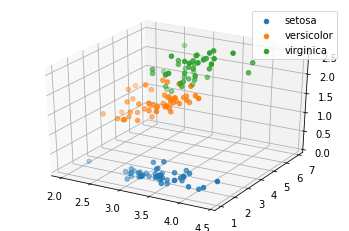

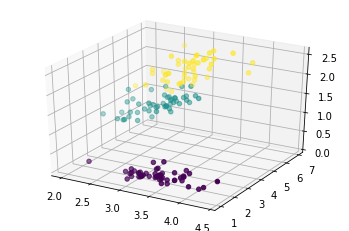

In [11]:
# Bonus:
from mpl_toolkits.mplot3d import Axes3D
labels = ['setosa', 'versicolor', 'virginica']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(3):
    smp = samples[model.labels_== i, :]
    ax.scatter(smp[:,1], smp[:,2], smp[:,3], label = labels[i])
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:,1], samples[:,2], samples[:,3], c=iris.target)
plt.show()

## Supervised learning

How about if we use an actual supervised algorithm such as the support vector machine to create a model?

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#train_data, test_data, train_labels, test_labels = train_test_split(samples, iris.target, test_size = 0.20)
clf = SVC(gamma='auto', kernel='linear')
clf.fit(samples, iris.target)
labels = clf.predict(samples)

ct = pd.crosstab(df.species, labels)
print(ct)

col_0        0   1   2
species               
setosa      50   0   0
versicolor   0  49   1
virginica    0   0  50


The supervised learning algoritm performs rather well without any preprocessing of the training data, with only one misclassification

#